# Projet (part 1) : Détection de motifs récurrents et classification

<b> Auteurs : </b> Damien BOUET, Pierre CHARDIN, Noé DEBROIS et Marion POIRIER<br>
<b> Date : </b> de Février 2022 à juillet 2022<br>
<b> Implication personnelle : </b> 60 heures


Dans un cadre, par exemple de surveillance nucléaire, ce système permettra de détecter en temps réel des potentielles anomalies ou comportements caractéristiques de la mesure du rayonnement gamma. Nous évaluerons pour cela le signal et regarderons s'il ressemble à certaines variations passées. Une fois ces motifs récurrents détectés, nous serons en mesure de les classifier, pour faciliter le travail de surveillance et d'analyse des opérateurs.

Utilité de ce système de détection et d'analyse :

- Utilisation en temps réel : Si la mesure de rayonnement en temps réel est similaire à une anomalie passée identifiée, ce système sera en mesure de détecter ce rayonnement et de le classifier, alertant ainsi automatiquement les personnes en charge que cette anomalie passée s'est reproduite.

- Analyse du passé : Le système sera en mesure de détecter des motifs récurrents dans l'historique du signal et de les classifier, les regrouper par groupes de signaux similaires. Les experts pourront alors étudier ces motifs et déterminer leur dangerosité ou leur cause. Ces motifs identifiés viendont alors enrichir la base de donnée de motifs identifiés pour permettre leur détection en temps réel comme décrit ci-dessus.

- La détection en temps réel d'anomalies jamais survenue sera effectuée dans la deuxième partie du projet (voir 2ème notebook)

Dans cette première partie du projet, le but sera donc de détecter dans un signal de rayonnement gamma des motifs récurrents, puis de les classifier.

##### Importations nécessaires

In [1]:
import pandas as pd
import numpy as np
import stumpy   #https://github.com/TDAmeritrade/stumpy.git
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score

import datetime as dt

# Partie I : Détection des deux meilleurs motifs

Dans cette partie, nous utiliserons l'algorithme de la Matrix Profile de la bibliothèque stumpy pour trouver les paires de motifs les plus similaires. 

## I/ A. Visualisation des données

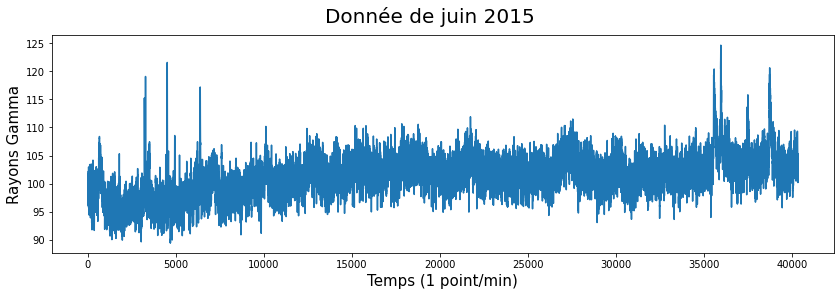

In [2]:
df = pd.read_csv("donnees/2015_gamma.txt", sep=',') #importation des données
mois = "juin" #choix du mois parmis : 'fevrier', 'avril', 'juin', 'octobre'

data_df=pd.DataFrame({'Values': df[mois]})
plt.figure(figsize=(14,4)) # changer la taille de la fenêtre de tracé
plt.suptitle('Donnée de juin 2015', fontsize='20')
plt.xlabel('Temps (1 point/min)', fontsize ='15')
plt.ylabel('Rayons Gamma', fontsize='15')
plt.plot(data_df["Values"])
plt.show()

## I/ B. Matrix Profile et meilleur motif

Text(0, 0.5, 'Meilleur couple de motifs')

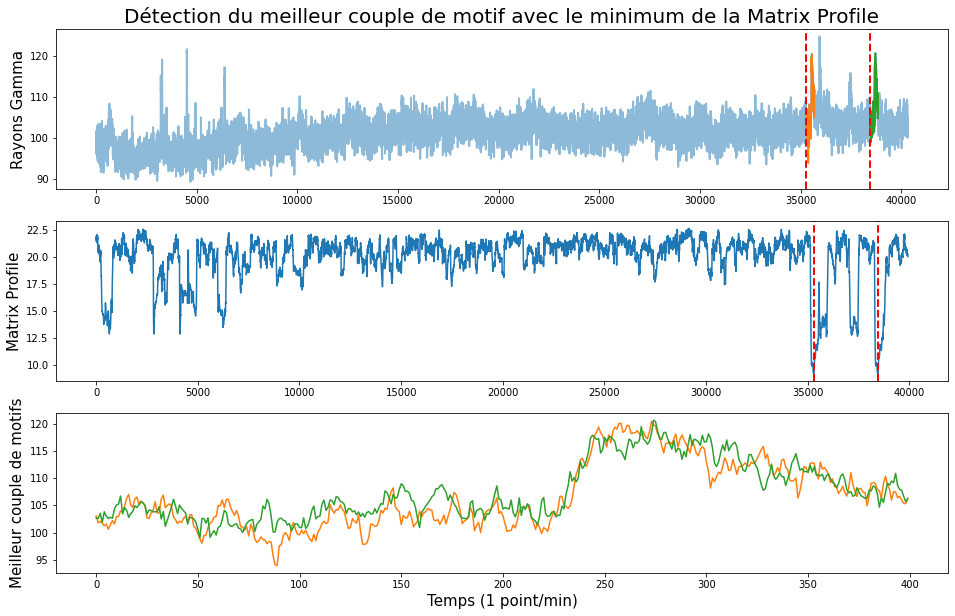

In [3]:
m = 400 #Choix de la largeur des motifs souhaités

mp = stumpy.stump(data_df['Values'], m=m)   #Calcul de la Matrix Profile

motif_idx = np.argsort(mp[:, 0])[0] #Calcul de la date du motif minimisant le Matrix Profile:
nearest_neighbor_idx = mp[motif_idx, 1] #Calcul du voisin le plus proche au sens du Matrix Profile:

plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.title("Détection du meilleur couple de motif avec le minimum de la Matrix Profile", fontsize="20")
plt.ylabel('Rayons Gamma', fontsize='15')
plt.plot(data_df['Values'], alpha=0.5, linewidth=2)
plt.plot(data_df['Values'].iloc[motif_idx:motif_idx+m])
plt.plot(data_df['Values'].iloc[nearest_neighbor_idx:nearest_neighbor_idx+m])
plt.axvline(x=motif_idx, linestyle="dashed", linewidth=2, c='r')
plt.axvline(x=nearest_neighbor_idx, linestyle="dashed", linewidth=2, c='r')

plt.subplot(3,1,2)
plt.ylabel("Matrix Profile", fontsize='15')
plt.plot(mp[:, 0])
plt.axvline(x=motif_idx, linestyle="dashed", linewidth=2, c='r')
plt.axvline(x=nearest_neighbor_idx, linestyle="dashed", linewidth=2, c='r')

plt.subplot(3,1,3)
plt.plot(data_df['Values'].values[motif_idx:motif_idx+m], color='C1')
plt.plot(data_df['Values'].values[nearest_neighbor_idx:nearest_neighbor_idx+m], color='C2')
plt.xlabel("Temps (1 point/min)", fontsize="15")
plt.ylabel("Meilleur couple de motifs", fontsize='15')

Plus la valeur de la Matrix Profile est faible, plus la paire de motif correspondante est similaire. On considère ici le minimum globale, qui nous donne la meilleure paire de motifs : ces deux motifs vert et orange sont en effet très similaires.

## I/ C. Impact de la largeur de la fenêtre

Nous devons en effet fixer la longueur des motifs recherchés, voyons l'impact de cette grandeur sur la position des minimaux locaux (et donc des motifs) détectés.

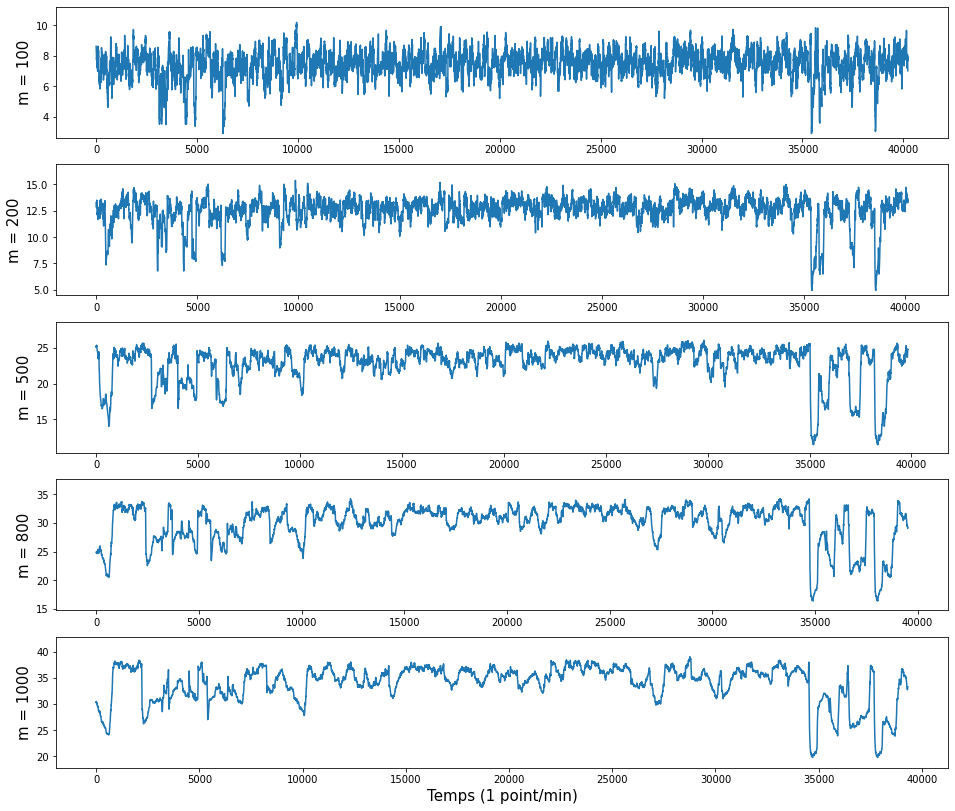

In [5]:
days_dict ={
  "100": 100,
  "200": 200,
  "500": 500,
  "800": 800,
  "1000": 1000,
}

days_df = pd.DataFrame.from_dict(days_dict, orient='index', columns=['m'])


plt.figure(figsize=(16,14))
plt.title("Matrix Profile pour différentes valeur de m", fontsize="20")
for i, varying_m in enumerate(days_df['m'].values):
  mp = stumpy.stump(data_df['Values'], varying_m) #Calcul de la Matrix Profile
  plt.subplot(5,1,i+1)
  plt.ylabel('m = '+str(varying_m), fontsize='15')
  
  
  plt.plot(mp[:, 0])
  plt.ylim((0.9*min(mp[:, 0]),1.1*max(mp[:, 0])))
  
plt.xlabel("Temps (1 point/min)", fontsize="15")
plt.show()


On observe que la Matrix Profile monte quand on augmente m, car si m > taille du motif, le bruit alentour augmente la valeur de la Matrix Profil. Mais globalement, les minimaux de la Matrix Profile restent des minimaux lorsqu'on augmente la largeur de m. 

Un des principale inconvénient est qu'il faut fixer arbitrairement, à l'avance, la largeur de la fenêtre m.
On a donc montré qu'on pouvait prendre une largeur trop grande sans que cela impact la détection des minimaux locaux et donc des motifs.

--> On choisit donc un m plutôt trop grand que trop petit

# Partie II : Matrix Profile multidimentionnelle 

Si nous nous intéressons au rayonnement gamma, nous avons aussi à notre disposition d'autre grandeurs atmosphériques, de température, d'hygrométrie et de pression. Ces autres grandeurs peuvent peut-être nous aider à détecter des motifs plus globaux, en considérant plusieurs signaux simultanément.

Nous étudierons donc ici la Matrix Profile multi-dimentionnelle, puis évaluerons son intérêt dans notre cas précis.

## II/A) Meilleur motif multi-dimentionnel

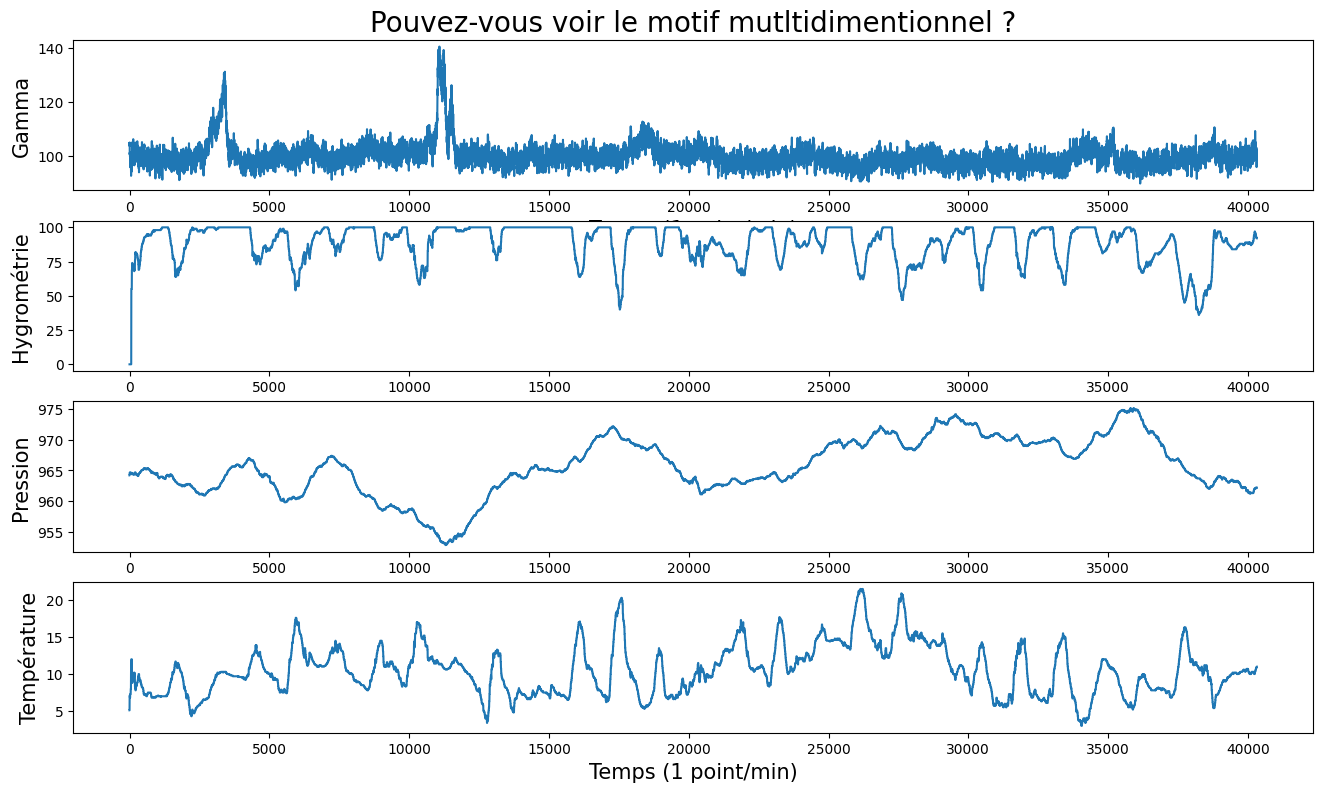

In [129]:
df_DebitDoseA = pd.read_csv("donnees/2015_gamma.txt")
df_Hygro = pd.read_csv("donnees/2015_months_HYGR.txt")
df_Patm = pd.read_csv("donnees/2015_months_PATM.txt")
df_Temp = pd.read_csv("donnees/2015_months_TEMP.txt")

moisDebitDoseA = df_DebitDoseA["octobre"]  #Choix du mois
moisHygro = df_Hygro["octobre"]
moisPatm = df_Patm["octobre"]
moisTemp = df_Temp["octobre"]

data_df = pd.DataFrame()
data_df["T1"] = moisDebitDoseA
data_df["T2"] = moisHygro
data_df["T3"] = moisPatm
data_df["T4"] = moisTemp


Labels = ["Gamma","Hygrométrie","Pression","Température"]
plt.figure(figsize=(16,9))
for i in range(data_df.shape[1]):
  plt.subplot(4,1,i+1)
  if(i==0): plt.title("Pouvez-vous voir le motif mutltidimentionnel ?", fontsize="20") #titre
  plt.ylabel(Labels[i], fontsize='15')
  plt.xlabel("Temps (1 point/min)", fontsize="15")  
  plt.plot(data_df[f'T{i + 1}'])

plt.show()


#### Trouver les k dimensions qui donnent le meilleur motif multi-dimentionnel

In [130]:
m = 800
mps, indices = stumpy.mstump(data_df, m)    #Matrix Profile
motifs_idx = np.argmin(mps, axis=1)         #liste de l'indice associé à motifs_idx[i]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

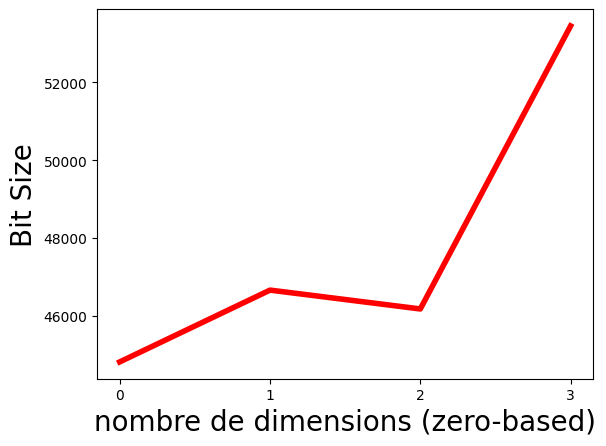

Nombre de dimension le plus meilleur : 1
Les 1 dimensions les meilleurs sont : Hygrométrie, 
Les 2 dimensions les meilleurs sont : Hygrométrie, Température, 
Les 3 dimensions les meilleurs sont : Hygrométrie, Pression, Température, 
Les 4 dimensions les meilleurs sont : Température, Hygrométrie, Pression, Gamma, 


In [131]:
mdls, subspaces = stumpy.mdl(data_df, m, motifs_idx, nn_idx)    #Minimum Description Length

plt.plot(np.arange(len(mdls)), mdls, c='red', linewidth='4')
plt.xlabel('nombre de dimensions (zero-based)', fontsize='20')
plt.ylabel('Bit Size', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.show()


dim = np.argmin(mdls)
print("Nombre de dimension le plus meilleur : " + str(dim+1))
for i in range(len(mdls)):
    res = "Les " + str(i+1)+" dimensions les meilleurs sont : "
    for j in subspaces[i]:
        res += Labels[j] + ", "
    print(res)

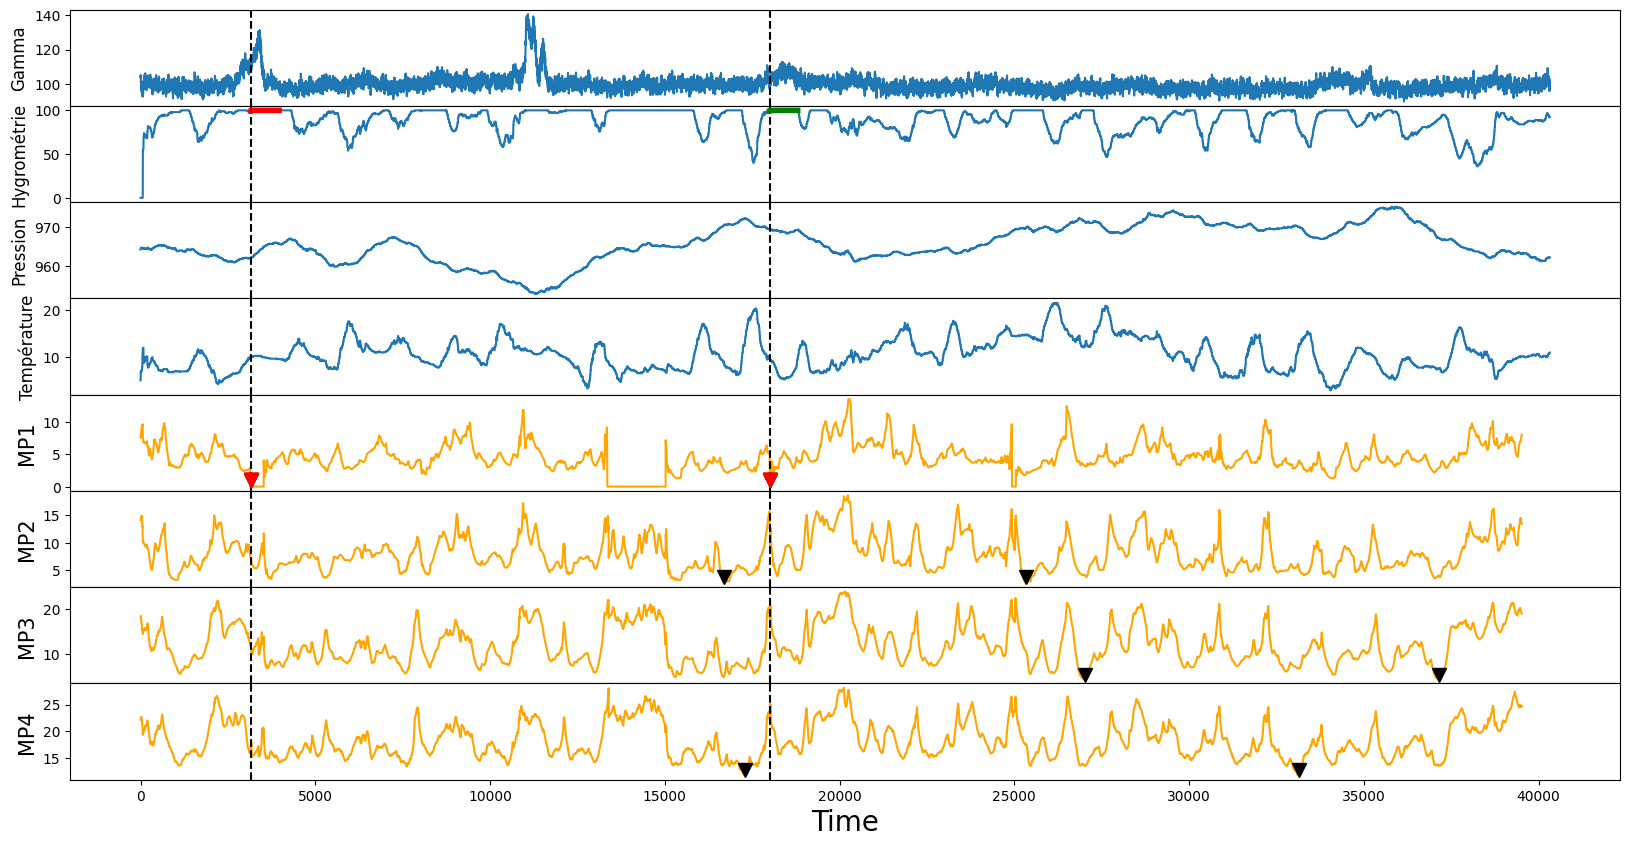

In [132]:
def print_res_multi_dim(mps,data_df,labels):

    fig, axs = plt.subplots(mps.shape[0] * 2, sharex=True, gridspec_kw={'hspace': 0}, figsize=(20,10))

    for k, dim_name in enumerate(data_df.columns):
        axs[k].set_ylabel(dim_name, fontsize='12')
        axs[k].plot(data_df[dim_name])
        axs[k].set_xlabel('Time', fontsize ='20')

        axs[k + mps.shape[0]].set_ylabel(dim_name.replace('T', 'MP'), fontsize='15')
        axs[k + mps.shape[0]].plot(mps[k], c='orange')
        axs[k + mps.shape[0]].set_xlabel('Time', fontsize ='20')

        # lignes pointillés noirs sur les Ti
        axs[k].axvline(x=motifs_idx[dim], linestyle="dashed", c='black')
        axs[k].axvline(x=nn_idx[dim], linestyle="dashed", c='black')

        # lignes pointillés noirs sur les Pi
        axs[k + mps.shape[0]].axvline(x=motifs_idx[dim], linestyle="dashed", c='black')
        axs[k + mps.shape[0]].axvline(x=nn_idx[dim], linestyle="dashed", c='black')

        if dim_name in data_df.columns[subspaces[dim]]:
            # sur les séries appartenant au sous-espace sélectionné

            # repères rouges sur les Ti
            axs[k].plot(range(motifs_idx[dim], motifs_idx[dim] + m), data_df[dim_name].iloc[motifs_idx[dim] : motifs_idx[dim] + m], c='red', linewidth=4)
            axs[k].plot(data_df[dim_name].iloc[nn_idx[dim] : nn_idx[dim] + m], c='green', linewidth=4)

            # repères rouges correspondant sur les Pi
            axs[dim + mps.shape[0]].plot(motifs_idx[dim], mps[dim, motifs_idx[dim]] + 1, marker="v", markersize=10, color='red')
            axs[dim + mps.shape[0]].plot(nn_idx[dim], mps[dim, nn_idx[dim]] + 1, marker="v", markersize=10, color='red')
        
        #else:
            # sur les séries n'appartenant pas au sous-espace sélectionné

        # on repère en noir les minima sur les matrix profiles Pi
        axs[k + mps.shape[0]].plot(motifs_idx[k], mps[k, motifs_idx[k]] + 1, marker="v", markersize=10, color='black')
        axs[k + mps.shape[0]].plot(nn_idx[k], mps[k, nn_idx[k]] + 1, marker="v", markersize=10, color='black')

        axs[dim + mps.shape[0]].plot(motifs_idx[dim], mps[dim, motifs_idx[dim]] + 1, marker="v", markersize=10, color='red')
        axs[dim + mps.shape[0]].plot(nn_idx[dim], mps[dim, nn_idx[dim]] + 1, marker="v", markersize=10, color='red')
    for i in range(len(data_df.columns)):
        axs[i].set_ylabel(Labels[i])
    plt.show()

Labels = ["Gamma","Hygrométrie","Pression","Température"]
print_res_multi_dim(mps,data_df,Labels)

MPi est la Matrix Profile à i dimension

En rouge : couple de motifs le meilleur \
En noir : meilleur couple pour les autres nombres de dimensions considérées \

On remarque que le meilleur motif multi-dimentionnel est ici à 1 dimension, celle de l'hygrométrie. Mais la courbe d'hygrométrie saturée à 100% donne obligatoirement on peut trouver une paire de motifs presque parfaits (on les voit en rouge, ce sont juste 2 moments de saturation)

## II/B) Meilleur motif multi-dimentionnel sans l'hygrométrie

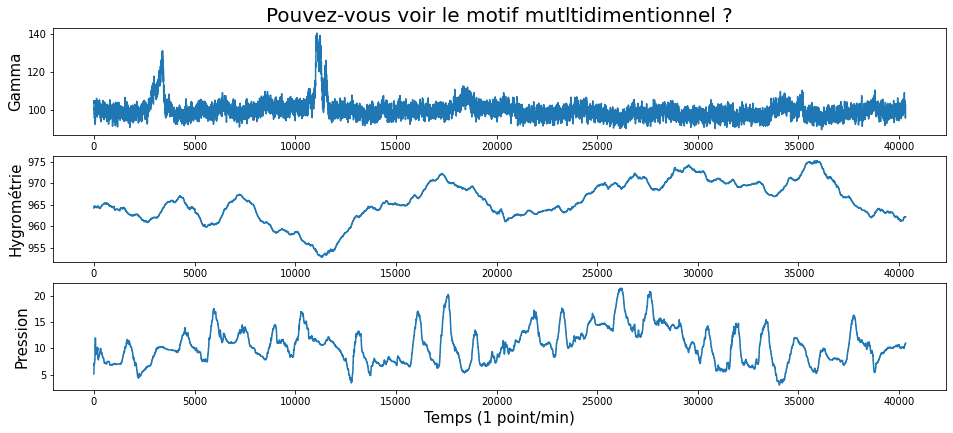

In [51]:
data_df = pd.DataFrame()
data_df["T1"] = moisDebitDoseA
data_df["T2"] = moisPatm
data_df["T3"] = moisTemp

plt.figure(figsize=(16,9))
for i in range(data_df.shape[1]):
  plt.subplot(4,1,i+1)
  if(i==0): plt.title("Pouvez-vous voir le motif mutltidimentionnel ?", fontsize="20") #titre
  plt.ylabel(Labels[i], fontsize='15')
  plt.xlabel("Temps (1 point/min)", fontsize="15")
  
  plt.plot(data_df[f'T{i + 1}'])
#   plt.ylim((0,25))
  
plt.show()


In [52]:
m = 800
mps, indices = stumpy.mstump(data_df, m)    #Matrix Profile
motifs_idx = np.argmin(mps, axis=1)         #liste de l'indice associé à motifs_idx[i]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

### Trouver les k dimensions les plus pertinentes

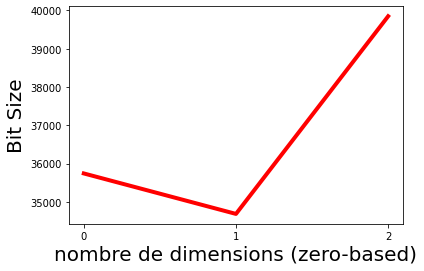

Nombre de dimension le plus meilleur : 2
Les 1 dimensions les meilleurs sont : Pression, 
Les 2 dimensions les meilleurs sont : Hygrométrie, Pression, 
Les 3 dimensions les meilleurs sont : Hygrométrie, Pression, Gamma, 


In [53]:
mdls, subspaces = stumpy.mdl(data_df, m, motifs_idx, nn_idx)

plt.plot(np.arange(len(mdls)), mdls, c='red', linewidth='4')
plt.xlabel('nombre de dimensions (zero-based)', fontsize='20')
plt.ylabel('Bit Size', fontsize='20')
plt.xticks(range(mps.shape[0]))
plt.show()


dim = np.argmin(mdls)
print("Nombre de dimension le plus meilleur : " + str(dim+1))
for i in range(len(mdls)):
    res = "Les " + str(i+1)+" dimensions les meilleurs sont : "
    for j in subspaces[i]:
        res += Labels[j] + ", "
    print(res)

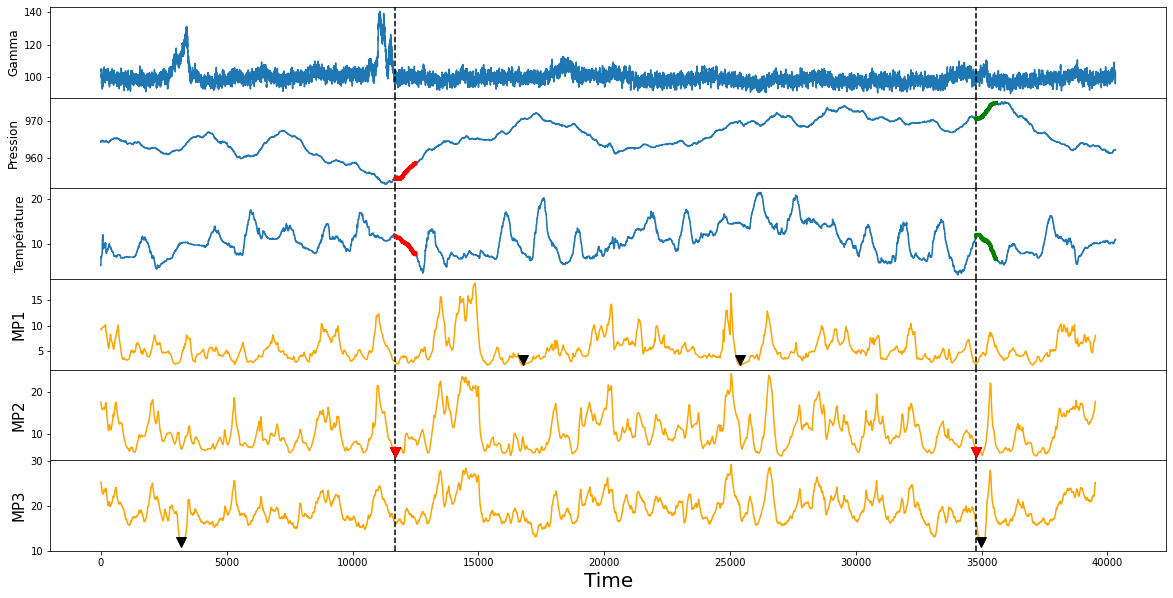

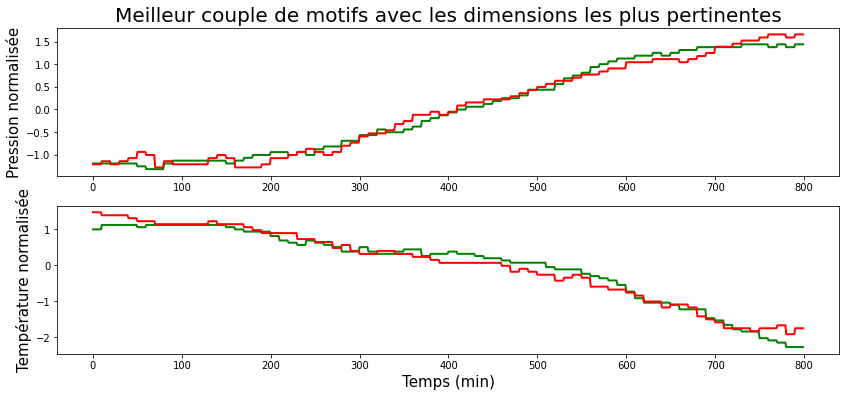

In [56]:
Labels = ["Gamma","Pression","Température"]

print_res_multi_dim(mps,data_df,Labels)

motif1_T2 = data_df["T2"][nn_idx[dim] : nn_idx[dim] + m]            #Meilleur couple de motifs
motif2_T2 = data_df["T2"][motifs_idx[dim] : motifs_idx[dim] + m]
motif1_T3 = data_df["T3"][nn_idx[dim] : nn_idx[dim] + m]
motif2_T3 = data_df["T3"][motifs_idx[dim] : motifs_idx[dim] + m]

plt.figure(figsize=(14,6))
plt.subplot(2,1,1)
plt.title("Meilleur couple de motifs avec les dimensions les plus pertinentes",fontsize="20")
plt.ylabel("Pression normalisée",fontsize="15")
plt.plot(range(m),(motif1_T2-np.mean(motif1_T2))/np.std(motif1_T2),color="green",linewidth=2)
plt.plot(range(m),(motif2_T2-np.mean(motif2_T2))/np.std(motif2_T2),color="red",linewidth=2)
plt.subplot(2,1,2)
plt.xlabel("Temps (min)",fontsize="15")
plt.ylabel("Température normalisée",fontsize="15")
plt.plot(range(m),(motif1_T3-np.mean(motif1_T3))/np.std(motif1_T3),color='green',linewidth=2)
plt.plot(range(m),(motif2_T3-np.mean(motif2_T3))/np.std(motif2_T3),color='red',linewidth=2)
plt.show()

On observe alors que le meilleur motif est un motif à deux dimensions, avec la pression et la température. Si ce motif multi-dimentionnel est en effet très similaire dans les 2 dimensions, on remarquera que le rayonnement gamma est systématiquement considéré en dernier, dans le choix des dimensions. 

Cela peut s'expliquer par le fait qu'il est beaucoup moins régulier, il sera donc plus dur de trouver un couple de motifs si similaire que celui ci-dessus, en considérant le rayonnement gamma. De plus, sa période caractéristique de variation est beaucoup plus faible que celle des autres signaux atmosphérique. La détection multi-dimentionnelle n'est donc pas intéressante dans notre cas. C'est pourquoi nous n'utiliserons que le rayonnement gamma dans la suite

# Partie III : Sélection des motifs et Classification

Maintenant que nous sommes capable de détecter des motifs récurrents dans le signal, nous allons les classifier. Nous devons d'abord extraire les meilleurs motifs en sélectionnant les plus petits minimaux locaux de la Matrix Profile, puis nous les classifierons à l'aide de la méthode des K-means.

## III/ A) Sélection des N meilleurs motifs : détection des minimaux locaux

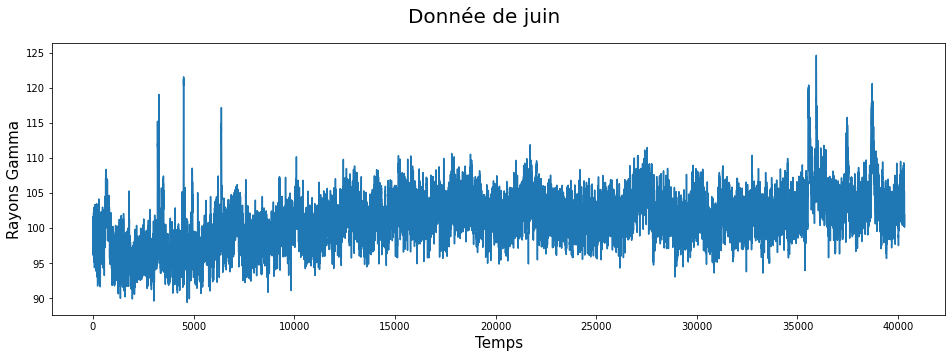

In [57]:
df = pd.read_csv("donnees/2015_gamma.txt", sep=',')
data_df = pd.DataFrame({'timestamp': np.arange(len(df["juin"])),"values":df["juin"]})

plt.figure(figsize=(16,5)) # changer la taille de la fenêtre de tracé
plt.suptitle('Donnée de juin', fontsize='20')
plt.xlabel('Temps', fontsize ='15')
plt.ylabel('Rayons Gamma', fontsize='15')
plt.plot(data_df["values"])
plt.show()

#### Sélection des N plus petits minimaux locaux

Nous choisissons de fixer arbitrairement le nombre de motifs que l'on souhaite détecter, car nous n'avons pas d'autres moyens de procédés. Nous n'avons en effet aucuns motifs labelisés sur des données passés ou critère théorique. 

Nous cherchons alors par exemple les 14 meilleurs motifs avec une largeur de 500 points

Nous utilisons argrelmin pour trouver des minimaux locaux, qui sont classé par valeur de matrix Profile croissante puis conservés s'ils ne l'était pas déjà

In [64]:
def select_motifs(mp,m,N):    

    from scipy.signal import argrelmin

    mp_df=pd.DataFrame(mp)
    del mp_df [2]
    del mp_df [3]

    mp_array=np.array(mp_df[0])

    #Sélection des tous les minimaux locaux dont la valeur de la Matrix Profile est inférieur à une certaines limite 
    #fixée de façon à avoir suffisamment de minimaux locaux pour, à la fin en avoir au moins N

    def is_not_already_selected(ind,motifs,m):      
        for tup in motifs:
            if( (abs(ind-tup[0])<m/2) ):
                return(False)
        return(True)

    c = 0
    X_lim = min(mp_array)+0.00001
    motifs = []
    while(len(motifs) < N and c<10000):
        c += 1
        x=argrelmin(mp_array,order=m//80) #prend min local et si deux min local on un écart de moins que order il prend le + petit (intéresant car sur un matrix profile de m=200 on parlera du même motif pour un pic et ses points autour de 100,150)
        x = x[0]
        minimums = np.zeros((len(x),2))
        for i in range(len(x)):
            minimums[i,:] = np.array([x[i],mp_array[x[i]]])

        minimums = np.array(sorted(minimums, key=lambda tup: tup[1])).astype(int)
        
        for ind in minimums[:,0]:
            if (len(motifs) >= N):
                break
            if(mp_array[ind]<=X_lim): #on prend les min locaux en desous de 8
                if(is_not_already_selected(ind,motifs,m)):
                    motifs.append([ind,mp_array[ind]])


        X_lim = 1.1*X_lim 

    motifs_sorted = sorted(motifs, key=lambda tup: tup[1])    #tri les minimum dans l'ordre croissant (les plus bas minimum d'abord)
    motifs_sorted = np.array(motifs,dtype=object)
    return(motifs_sorted)


m = 500
N = 14
mp = stumpy.stump(data_df['values'], m)

motifs_sorted = select_motifs(mp,m,N)

#### Visualisation des N minimaux locaux trouvés

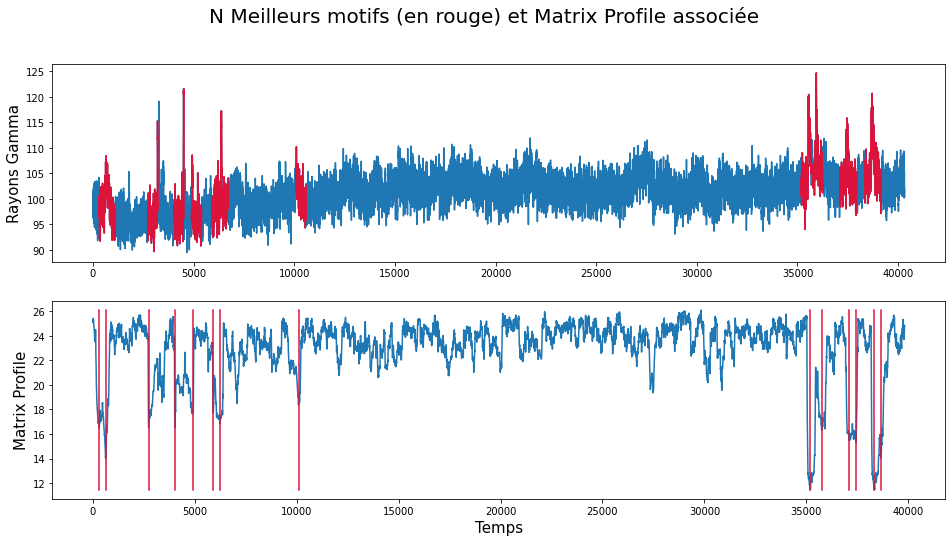

In [65]:
plt.figure(figsize=(16,8)) # changer la taille de la fenêtre de tracé

plt.suptitle('N Meilleurs motifs (en rouge) et Matrix Profile associée', fontsize='20')
plt.subplot(2,1,1)
plt.ylabel('Rayons Gamma', fontsize='15')
plt.plot(data_df["timestamp"],data_df["values"])

for paire in motifs_sorted:
    plt.plot(data_df["timestamp"][paire[0]:paire[0]+m],data_df["values"][paire[0]:paire[0]+m],color='crimson')

plt.subplot(2,1,2)
plt.xlabel('Temps', fontsize ='15')
plt.ylabel('Matrix Profile', fontsize='15')
plt.plot(np.arange(len(mp[:,0])),mp[:,0])

for paire in motifs_sorted:
    plt.plot([paire[0],paire[0]],[min(mp[:,0]),max(mp[:,0])],color='crimson')

plt.show()

## III/ B) Classification : méthode des K-means
#### Trouver le nombre de clusters optimal

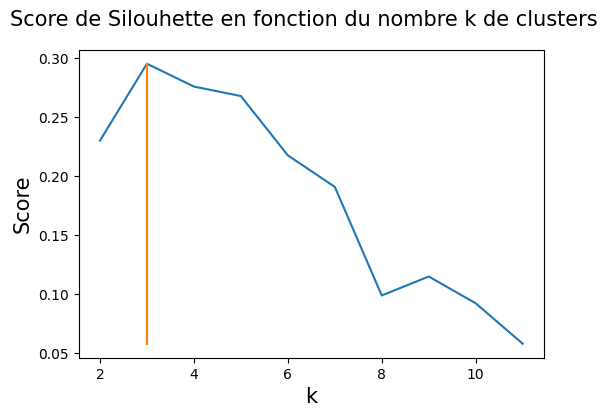

Nombre de clusters optimal : 3
[1 1 0 0 0 1 2 1 1 2 0 0]


In [69]:
import matplotlib

matplotlib.rcdefaults()

data = data_df['values']
W=[]
for i in range(len(motifs_sorted[:,0])):
    if not(i in [9,12]):
        y = np.array(data[motifs_sorted[i][0]:motifs_sorted[i][0]+m])
        W.append((y - np.mean(y))/np.std(y)) 

scores = {}
for n_clusters in range(2,len(W)):
    model_eucl=TimeSeriesKMeans(n_clusters, n_init=10)

    prediction_eucl = model_eucl.fit_predict(W)
    silhouette_avg = silhouette_score(W, prediction_eucl)
    scores[n_clusters] = silhouette_avg

scores[2] = 0.23
plt.figure(figsize=(6,4))
plt.suptitle('Score de Silouhette en fonction du nombre k de clusters', fontsize='15')
plt.xlabel('k', fontsize ='15')
plt.ylabel('Score', fontsize='15')
plt.plot(scores.keys(),scores.values())
k_opt = [k for k, v in scores.items() if v == max(scores.values())][0]
plt.plot([k_opt,k_opt],[min(scores.values()),max(scores.values())])
plt.grid(False)
plt.show()

print("Nombre de clusters optimal : " + str(k_opt))
model_eucl=TimeSeriesKMeans(k_opt, n_init=10) 

prediction_eucl = model_eucl.fit_predict(W)

print(prediction_eucl)

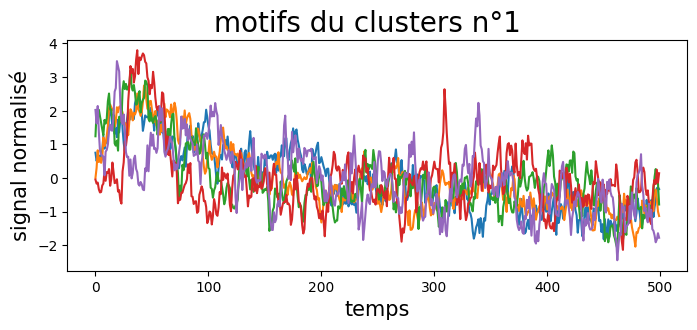

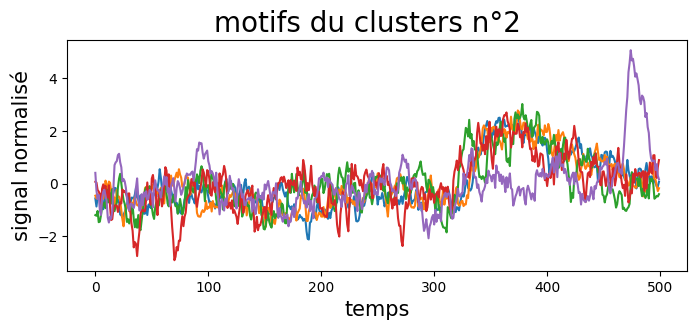

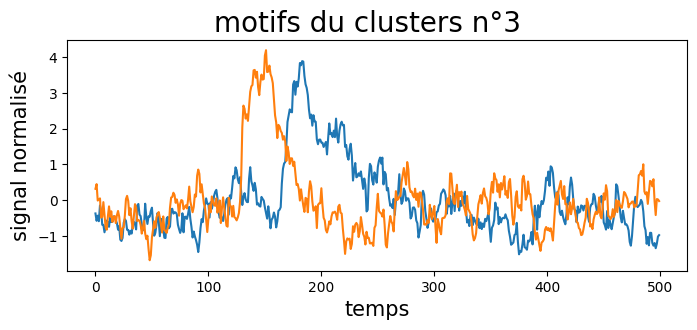

In [77]:
Z=['red','blue','magenta','grey','green','yellow','black','purple','cyan','cadetblue','blueviolet']
for i in range(k_opt):
    plt.figure(figsize=(8,3))
    for j in range(len(W)):
        if i==prediction_eucl[j]:
            plt.plot(np.arange(m),W[j],alpha=1) #gr.signal_debruite(W[j],1)data[L[j]:L[j]+m]
    plt.suptitle('motifs du clusters n°'+str(i+1), fontsize='20')
    plt.xlabel('temps', fontsize ='15')
    plt.ylabel('signal normalisé', fontsize='15')
    plt.show()

Les 3 clusters regroupent en effet des motifs similaires :
- le premier correspond à des motifs qui ont une bosse au début du motifs
- le deuxième à la fin
- et le troisième, au milieu 

On remarque cependant que la détection du début des motifs n'est pas très précise : en effet, dans le cas du 3ème cluster, on voit qu'il s'agit en fait simplement d'un couple de motif, mais on aurait souhaité que les 2 pics soient superposés, ce qui n'est pas le cas.

# Partie IV : évaluation des performances

Pour évaluer les performances plus précisement, on va créer nous même des signaux avec des motifs particuliers. On saura ainsi où sont vraiment les motifs (alors qu'on ne le savais pas dans les signaux réels). On pourra ainsi vraiment évaluer les performances de la méthode

## IV/ A) Génération de signaux test

### IV/ A) 1. Générations de 4 motifs différents

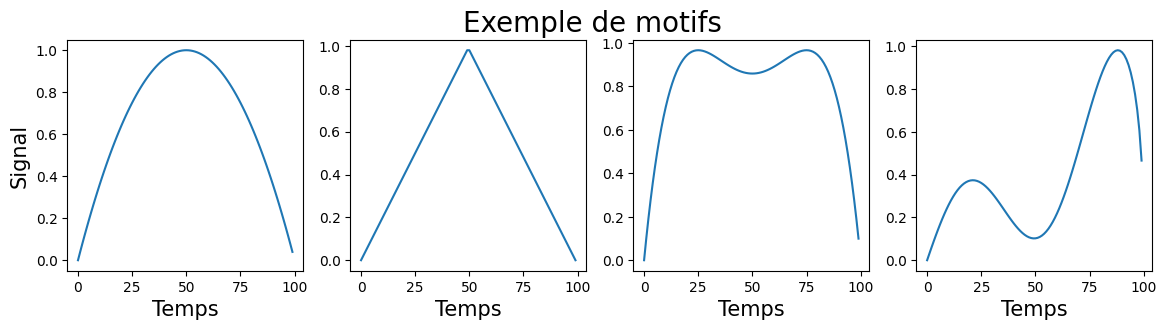

In [81]:
m = 100
motif1 = np.array([k/m*(1-k/m)*4*20 for k in range(m)])/20
motif2= np.array([k/2 for k in range(m//2)] + [(m//2-1-k)/2 for k in range(m//2)])/25
motif3= np.array([-2200*((k/m)**4/4-1.5/3*(k/m)**3+0.6875/2*(k/m)**2-0.09375*(k/m)) for k in range(m)])/20
motif4 = np.array([27*((1.2+np.cos(2*3.1415*k/m))*k/m*(1-k/m)**0.4) for k in range(m)])/20

plt.figure(figsize=(14,3))
plt.suptitle("Exemple de motifs",fontsize="20")
plt.subplot(1,4,1)
plt.xlabel("Temps",fontsize="15")
plt.ylabel("Signal",fontsize="15")
plt.plot(motif1)
plt.subplot(1,4,2)
plt.xlabel("Temps",fontsize="15")
plt.plot(motif2)
plt.subplot(1,4,3)
plt.xlabel("Temps",fontsize="15")
plt.plot(motif3)
plt.subplot(1,4,4)
plt.xlabel("Temps",fontsize="15")
plt.plot(motif4)
plt.show()

In [82]:
def signal_debruite(signal,l):
    L = []
    signal_agrandi = np.concatenate((signal[l:0:-1],signal,signal[-2:-l-2:-1]),axis=0)
    #Exemple avec l=2: [1, 2, 3, 4, 5, 6, 7] devient [3 2 1 2 3 4 5 6 7 6 5]
    for i in range(l,len(signal)+l):
        L.append(sum(signal_agrandi[i-l:i+l+1])/(2*l+1))
    return np.array(L)


def amplitude(motif,ratio):
    return np.copy(motif)*ratio


def amplitude_aleatoire(motif,ecart):
    """
    modifie l'amplitide avec un rapport guassien d'écart type "ecart"
    Il faut choisir un écart type ingérieur à 0.25 !
    """
    return amplitude(motif,np.random.normal(1,ecart)**2)

import math
def slicing(motif,ratio):
    """dilate ou contracte le signal sur l'axe temporel"""
    L=[]
    t=0
    pas = 1/ratio
    while t < len(motif):
        L.append(motif[math.floor(t)])
        t+=pas
    return np.array(L)


### IV/ A) 2. Création d'un signal uni-dimentionnel

#### IV/ A) 2. a/ Signal composé de N motifs similaires (bruités et dilatés temporellement et spacialement) 

In [83]:
def signal_motif(motif,nbr_motif,bruit=True,moy_bruit=0,ecart_bruit=0.2,amplitude=False,ecart_amplitude=0.1, dilatation=False,dilatation_ecart=0.2,bruit_sur_motif=True):
    """
        Crée le signal à partir du motif :
        ----------------------------------------
        motif : liste des points du motif
        nbr_motif : nombre de motif à mettre dans le signal
        -----------------------------------------
        bruit : booléan, Rajoute du bruit si True
        moy_bruit : moyenne du bruit gaussien rajouté
        ecart_bruit : écart-type du bruit gaussien rajouté
        ----------------------------------------------
        amplitude : booléan, Modifie de façon aléatoire l'amplitude si True
        ecart_amplitude : écart-type de la modification gaussienne de la moyenne
        -> Utiliser un ecart_amplitude < 0.25
        -------------------------------------------------
        dilatation : Booléan, dilate ou contract le motif (change l'échelle des temps) si True
        dilatation_ecart :  ecart-type du ratio de dilatation/contraction
    """
    l=round(3*(nbr_motif+1)*len(motif))
    L = [None]*l  #On fait une liste de None
    k = 0
    while k < nbr_motif:
        if(dilatation):
            vrai_motif = slicing(motif,np.random.normal(1,dilatation_ecart)**2)
        else :
            vrai_motif = np.copy(motif)

        x = np.random.randint(0,l-1-len(vrai_motif)) #position aléatoire (pas trop pres de la fin pour que le motif puisse être ajouté entier)
        if L[x:x+len(vrai_motif)] == [None]*len(vrai_motif):  #si le motif est placé sur un endroit vide
            if(amplitude):
                motif_ampli = amplitude_aleatoire(vrai_motif,ecart_amplitude)
                L[x:x+len(vrai_motif)] = motif_ampli
            else:
                L[x:x+len(vrai_motif)] = vrai_motif
            k += 1
    for i in range(len(L)):
        if(L[i]==None): 
            L[i] = bruit*np.random.normal(moy_bruit,ecart_bruit)
        else:
            if(bruit_sur_motif):
                L[i] += bruit*np.random.normal(moy_bruit,ecart_bruit)
        
    return np.array(L)


#### Exemple :

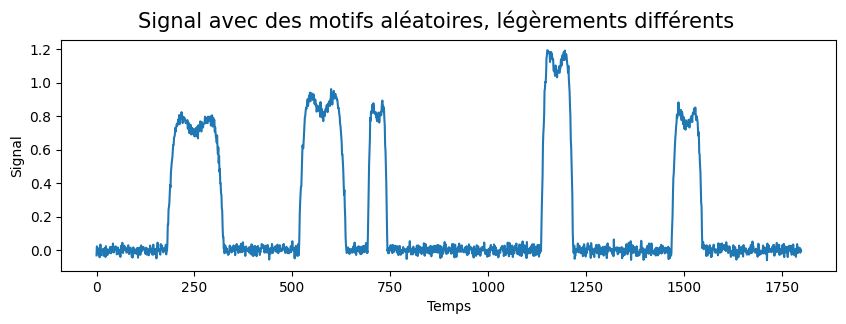

In [91]:
signal = signal_motif(motif3,nbr_motif=5,
                    bruit=True, moy_bruit=0, ecart_bruit=0.02,
                    amplitude=True, ecart_amplitude=0.1, 
                    dilatation=True, dilatation_ecart=0.2,
                    bruit_sur_motif=True)

plt.figure(figsize=(10,3))
plt.suptitle("Signal avec des motifs aléatoires, légèrements différents",fontsize="15")
plt.xlabel("Temps",fontsize="10")
plt.ylabel("Signal",fontsize="10")
plt.plot(signal)
plt.show()

#### IV/ A) 2. b/ Signal composé de plusieurs types de motifs (bruités et dilatés temporellement et spacialement) 

In [92]:
def signal_motifs(motifs,nbr_motif,bruit=True,moy_bruit=0,ecart_bruit=0.1,amplitude=False,ecart_amplitude=0.05, dilatation=False,dilatation_ecart=0.05,bruit_sur_motif=True):
    """
        Crée le signal à partir du motif :
        ----------------------------------------
        motif : liste des points du motif
        nbr_motif : nombre de motif à mettre dans le signal
        -----------------------------------------
        bruit : booléan, Rajoute du bruit si True
        moy_bruit : moyenne du bruit gaussien rajouté
        ecart_bruit : écart-type du bruit gaussien rajouté
        ----------------------------------------------
        amplitude : booléan, Modifie de façon aléatoire l'amplitude si True
        ecart_amplitude : écart-type de la modification gaussienne de la moyenne
        -> Utiliser un ecart_amplitude < 0.25
        -------------------------------------------------
        dilatation : Booléan, dilate ou contract le motif (change l'échelle des temps) si True
        dilatation_ecart :  ecart-type du ratio de dilatation/contraction
    """
    list_ind = []

    l=round(2*(nbr_motif+1)*len(motifs[0]))
    L = [None]*l  #On fait une liste de None
    k = 0
    nbr = 0
    while k < nbr_motif and nbr<1000:
        nbr+=1
        num_motif = np.random.randint(0,len(motifs))
        if(dilatation):
            vrai_motif = slicing(motifs[num_motif],np.random.normal(1,dilatation_ecart)**2)
        else :
            vrai_motif = np.copy(motifs[num_motif])

        x = np.random.randint(0,l-1-len(vrai_motif)) #position aléatoire (pas trop pres de la fin pour que le motif puisse être ajouté entier)
        if np.array_equal(np.array(L[x:x+len(vrai_motif)]),np.array([None]*len(vrai_motif))):  #si le motif est placé sur un endroit vide
            if(amplitude):
                motif_ampli = amplitude_aleatoire(vrai_motif,ecart_amplitude)
                L[x:x+len(vrai_motif)] = motif_ampli
                list_ind.append(x)
            else:
                L[x:x+len(vrai_motif)] = vrai_motif
                list_ind.append(x)
            k += 1
    for i in range(len(L)):
        if(L[i]==None): 
            L[i] = bruit*np.random.normal(moy_bruit,ecart_bruit)
        else:
            if(bruit_sur_motif):
                L[i] += bruit*np.random.normal(moy_bruit,ecart_bruit)

    return (np.array(L),list_ind)

#### Exemple

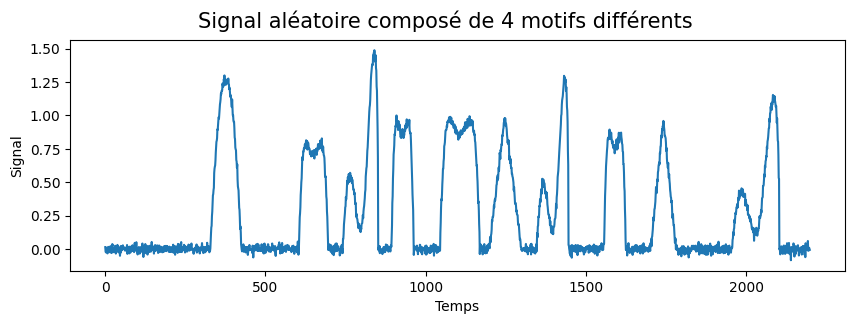

In [96]:
motifs=[motif1,motif2,motif3,motif4]

signal,inds = signal_motifs(motifs,nbr_motif=10,
                    bruit=True, moy_bruit=0, ecart_bruit=0.02,
                    amplitude=True, ecart_amplitude=0.1, 
                    dilatation=True, dilatation_ecart=0.1,
                    bruit_sur_motif=True)

plt.figure(figsize=(10,3))
plt.suptitle("Signal aléatoire composé de 4 motifs différents",fontsize="15")
plt.xlabel("Temps",fontsize="10")
plt.ylabel("Signal",fontsize="10")
plt.plot(signal)
plt.show()

### IV/ A) 2. Création d'un signal multi-dimentionnel

In [150]:
def generation_test_multidim(dicomotif, nbr_motif=5, retard=True, bruit=True, dilatation=True): 
    
    longueur =round(2*(nbr_motif+1)*len(motifs[0]))
    bruit_var = 0.02
    dilat_var = 0.1 # < 0.25
    ampli_var = 0.10 # < 0.25

    if bruit:
        L1, L2, L3, L4 = [np.random.normal(0,bruit_var) for k in range(longueur)],[np.random.normal(0,bruit_var) for k in range(longueur)],[np.random.normal(0,bruit_var) for k in range(longueur)],[np.random.normal(0,bruit_var) for k in range(longueur)]
    else:
        L1, L2, L3, L4 = [0 for _ in range(longueur)],[0 for _ in range(longueur)],[0 for _ in range(longueur)],[0 for _ in range(longueur)]
    
    S = np.zeros((len(dicomotif),longueur))
    S[0,:] = L1
    S[1,:] = L2
    S[2,:] = L3
    S[3,:] = L4


    Nbr = [k for k in range(len(dicomotif))]
    
    np.random.shuffle(Nbr)

    m1 = np.copy(dicomotif[Nbr[0]])
    m2 = np.copy(dicomotif[Nbr[1]])
    m3 = np.copy(dicomotif[Nbr[2]])
    m4 = np.copy(dicomotif[Nbr[3]])

    Max = max([len(m1), len(m2), len(m3), len(m4)]) 

    retard_var = Max/2
    
    list_x = []
    absci = np.zeros((4,nbr_motif),dtype=int)
    for k in range(nbr_motif):
        test= True
        count = 0
        while(test and count<100):
            count += 1
            absci[0][k] = np.random.randint(0, longueur-m)
            test = False
            for x in list_x:
                if(abs(x-absci[0][k]) < Max):
                    test = True
                    break;
        list_x.append(absci[0][k])

        for j in range(1,4):
            absci[j][k] = absci[0][k]
            
    r = np.ones((4,nbr_motif),dtype=float)
    if dilatation : 
        for k in range(nbr_motif):
            for j in range(0,4):
                r[j][k] = np.random.normal(1,dilat_var)**2

    if bruit : 
        m1 += np.random.normal(0,bruit_var,len(m1))
        m2 += np.random.normal(0,bruit_var,len(m2))
        m3 += np.random.normal(0,bruit_var,len(m3))
        m4 += np.random.normal(0,bruit_var,len(m4))
    if retard : 
        for j in range(nbr_motif) : 
            absci[1][j] += max(-absci[0][j],min(round(np.random.normal(0,retard_var)),longueur-absci[0][j]-len(m2)))
            absci[2][j] += max(-absci[0][j],min(round(np.random.normal(0,retard_var)),longueur-absci[0][j]-len(m3)))
            absci[3][j] += max(-absci[0][j],min(round(np.random.normal(0,retard_var)),longueur-absci[0][j]-len(m4)))
#a2, a3, a4 = a1+np.random.randint(0,longueur-a1-len(m2)), a1+np.random.randint(0,longueur-a1-len(m3)), a1+np.random.randint(0,longueur-a1-len(m4))
    for j in range(nbr_motif): 
        res = slicing(m1, r[0][j])
        L1[absci[0][j]:absci[0][j]+len(res)]=res
        res = slicing(m2, r[1][j])
        L2[absci[1][j]:absci[1][j]+len(res)]=res
        res = slicing(m3, r[2][j])
        L3[absci[2][j]:absci[2][j]+len(res)]=res
        res = slicing(m4, r[3][j])
        L4[absci[3][j]:absci[3][j]+len(res)]=res

    S[0,:] = L1[0:longueur]
    S[1,:] = L2[0:longueur]
    S[2,:] = L3[0:longueur]
    S[3,:] = L4[0:longueur]
    return np.array(S)


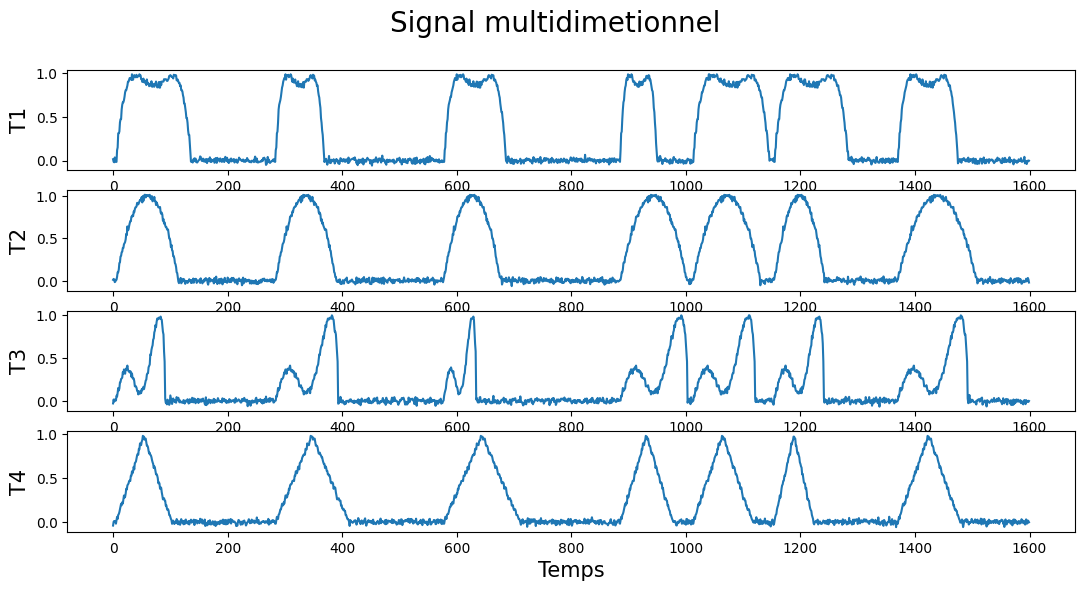

In [110]:
res = generation_test_multidim(motifs, 7,False,True,True)
plt.figure(figsize=(13,6))
plt.suptitle("Signal multidimetionnel", fontsize='20')
plt.subplot(4,1,1)
plt.ylabel("T1", fontsize='15')
plt.plot(res[0])
plt.subplot(4,1,2)
plt.ylabel("T2", fontsize='15')
plt.plot(res[1])
plt.subplot(4,1,3)
plt.ylabel("T3", fontsize='15')
plt.plot(res[2])
plt.subplot(4,1,4)
plt.ylabel("T4", fontsize='15')
plt.plot(res[3])
plt.xlabel('Temps', fontsize='15')
plt.show()

## IV/ B) Evaluation des performances

### IV/ B) 1. Sélection des dimentions les plus pertinentes dans le cas multi-dimentionnel

#### IV/ B) 1. a/ Cas où les dimensions dont très corrélées

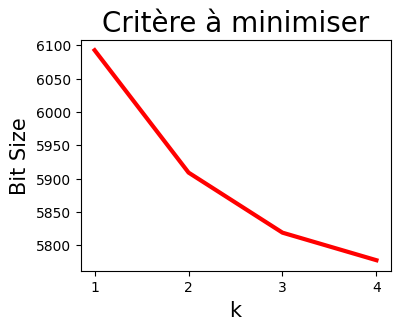

Il est préférable de choisir 4 dimensions


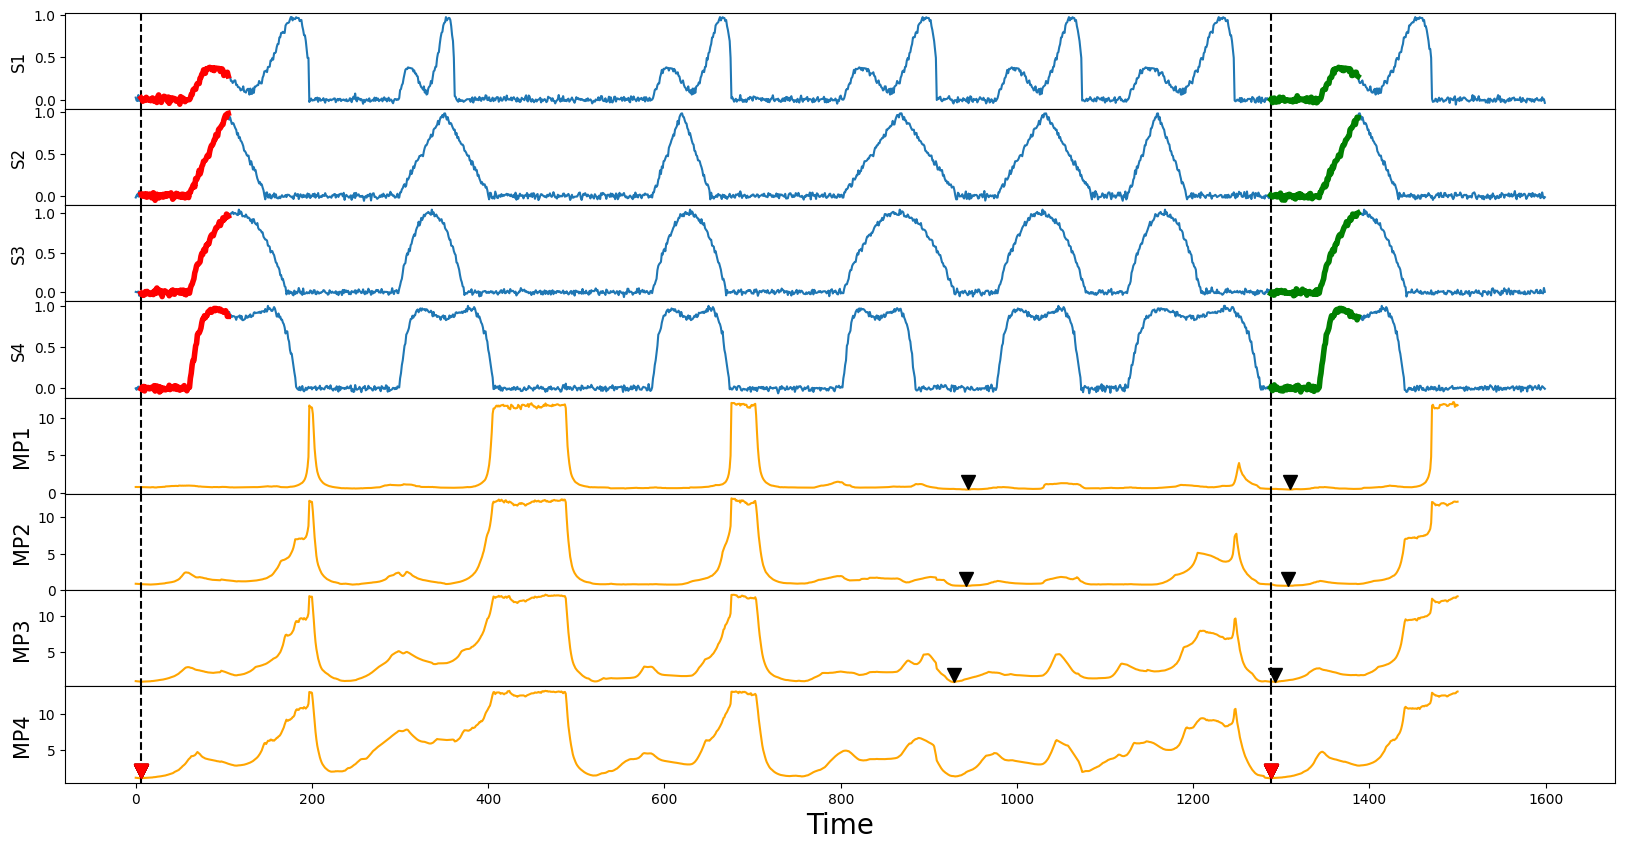

In [143]:
res = generation_test_multidim(motifs, 7,False,True,True)

data_df = pd.DataFrame()
data_df["T1"] = res[0]
data_df["T2"] = res[1]
data_df["T3"] = res[2]
data_df["T4"] = res[3]


m = 100
mps, indices = stumpy.mstump(data_df, m)    #Matrix Profile
motifs_idx = np.argmin(mps, axis=1)         #liste de l'indice associé à motifs_idx[i]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

mdls, subspaces = stumpy.mdl(data_df, m, motifs_idx, nn_idx)

plt.figure(figsize=(4,3))
plt.title("Critère à minimiser",fontsize="20")
plt.plot(np.arange(1,len(mdls)+1), mdls, c='red', linewidth='3')
plt.xlabel('k', fontsize='15')
plt.ylabel('Bit Size', fontsize='15')
plt.xticks(range(1,len(mdls)+1))
plt.show()

dim = np.argmin(mdls)

print("Il est préférable de choisir " + str(dim+1) + " dimensions")

Labels = ["S1","S2","S3","S4"]
print_res_multi_dim(mps,data_df,Labels)

Il est bien conseillé de sélectionner toutes les dimensions, comme on l'aurait supposé, car les 4 dimensions sont très corrélées

#### IV/ B) 1. a/ Cas où les dimensions dont peu corrélées

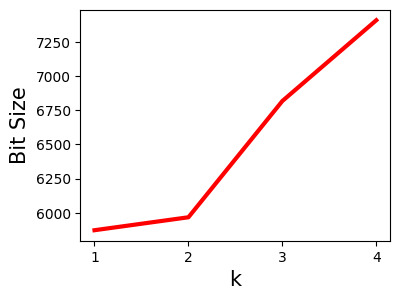

Il est préférable de choisir 1 dimensions


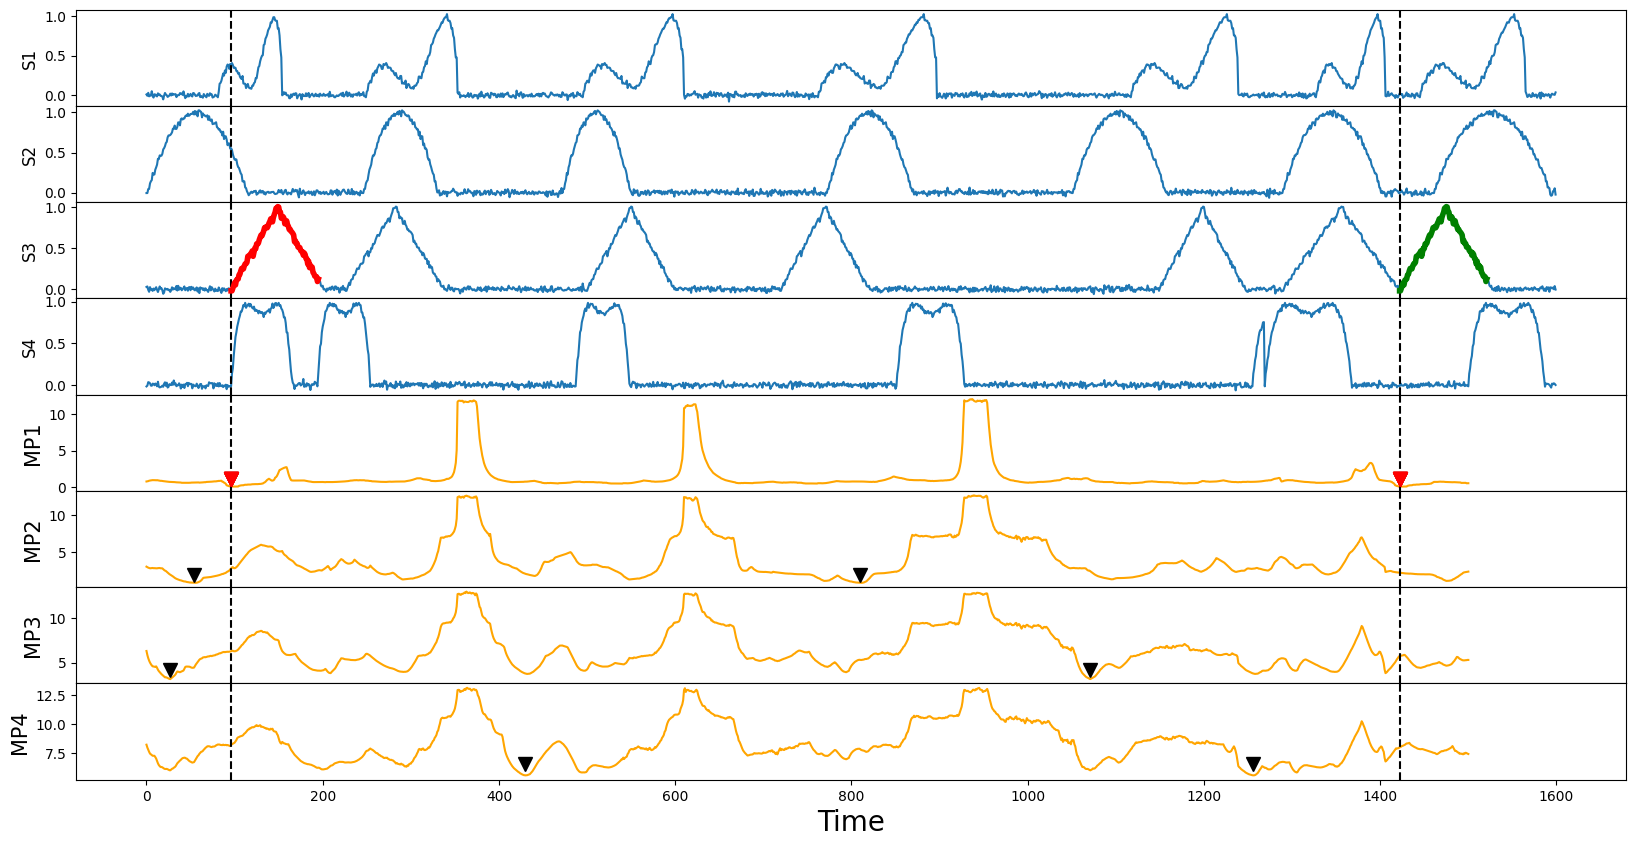

In [154]:
res = generation_test_multidim(motifs, 7,True,True,True)

data_df = pd.DataFrame()
data_df["T1"] = res[0]
data_df["T2"] = res[1]
data_df["T3"] = res[2]
data_df["T4"] = res[3]


m = 100
mps, indices = stumpy.mstump(data_df, m)    #Matrix Profile
motifs_idx = np.argmin(mps, axis=1)         #liste de l'indice associé à motifs_idx[i]
nn_idx = indices[np.arange(len(motifs_idx)), motifs_idx]

mdls, subspaces = stumpy.mdl(data_df, m, motifs_idx, nn_idx)

plt.figure(figsize=(4,3))
plt.plot(np.arange(1,len(mdls)+1), mdls, c='red', linewidth='3')
plt.xlabel('k', fontsize='15')
plt.ylabel('Bit Size', fontsize='15')
plt.xticks(range(1,len(mdls)+1))
plt.show()

dim = np.argmin(mdls)

print("Il est préférable de choisir " + str(dim+1) + " dimensions")

Labels = ["S1","S2","S3","S4"]
print_res_multi_dim(mps,data_df,Labels)

Il est bien conseillé de sélectionner une seule dimension, comme on l'aurait supposé, car les 4 dimensions sont très peu corrélées : il n'y a donc pas vraiment de motifs multi-dimentionnels très similaires.

### IV/ B) 2. Précision de la détection des indices des motifs

#### IV/ B) 2. a/ Détection de motifs bruités

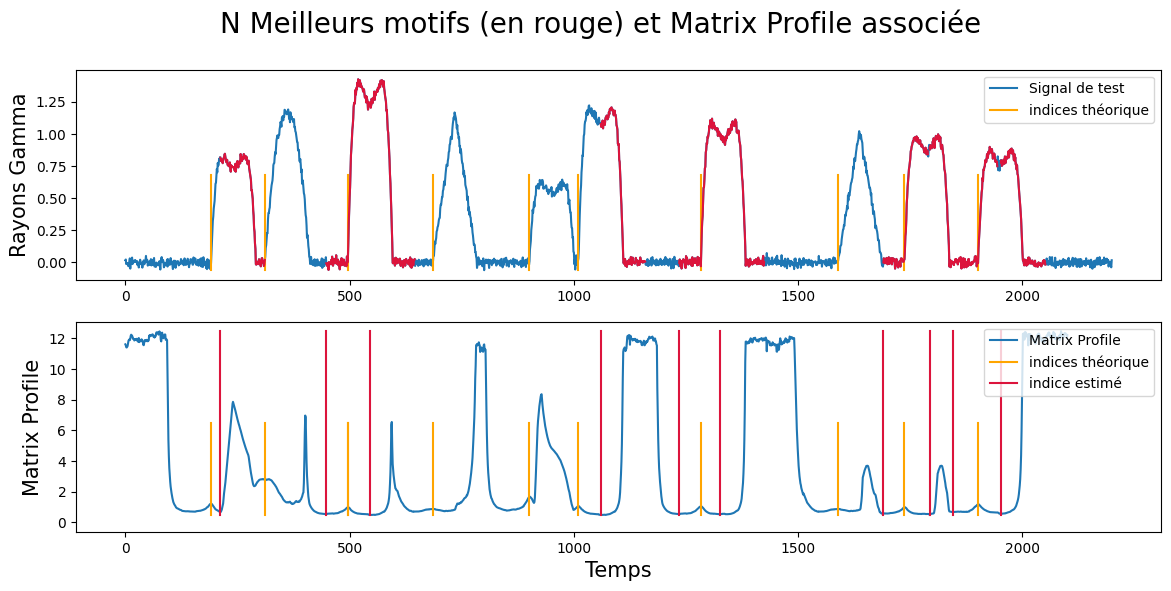

In [183]:
m = 100
N=10

motifs=[motif1,motif2,motif3,motif4]

signal,inds = signal_motifs(motifs,nbr_motif=10,
                    bruit=True, moy_bruit=0, ecart_bruit=0.02,
                    amplitude=True, ecart_amplitude=0.1, 
                    dilatation=False, dilatation_ecart=0.1,
                    bruit_sur_motif=True)
                    
data_df=pd.DataFrame({"timestamp":np.arange(len(signal)),'values': signal})


mp = stumpy.stump(data_df['values'], m)

L = select_motifs(mp,m,N)


def plot_mutli_dim_theorique_et_detecte(data_df,mp,inds,L):
    plt.figure(figsize=(14,6)) # changer la taille de la fenêtre de tracé

    plt.suptitle('N Meilleurs motifs (en rouge) et Matrix Profile associée', fontsize='20')
    plt.subplot(2,1,1)
    plt.ylabel('Rayons Gamma', fontsize='15')
    plt.plot(data_df["timestamp"],data_df["values"])

    for i in inds:
        plt.plot([i,i],[min(data_df["values"]),(min(data_df["values"])+max(data_df["values"]))/2],color='orange')
    for motif in L:
        plt.plot(data_df["timestamp"][motif[0]:motif[0]+m],data_df["values"][motif[0]:motif[0]+m],color='crimson')

    plt.legend(["Signal de test","indices théorique"], loc ="upper right")

    plt.subplot(2,1,2)
    plt.xlabel('Temps', fontsize ='15')
    plt.ylabel('Matrix Profile', fontsize='15')
    plt.plot(np.arange(len(mp[:,0])),mp[:,0])

    plt.plot([inds[0],inds[0]],[min(mp[:,0]),(min(mp[:,0])+max(mp[:,0]))/2],color='orange')

    for motif in L:
        plt.plot([motif[0],motif[0]],[min(mp[:,0]),max(mp[:,0])],color='crimson')
    for i in inds:
        plt.plot([i,i],[min(mp[:,0]),(min(mp[:,0])+max(mp[:,0]))/2],color='orange')

    plt.legend(["Matrix Profile","indices théorique","indice estimé"], loc ="upper right")

    plt.plot([len(signal)-1],[0])

    plt.show()

plot_mutli_dim_theorique_et_detecte(data_df,mp,inds,L)

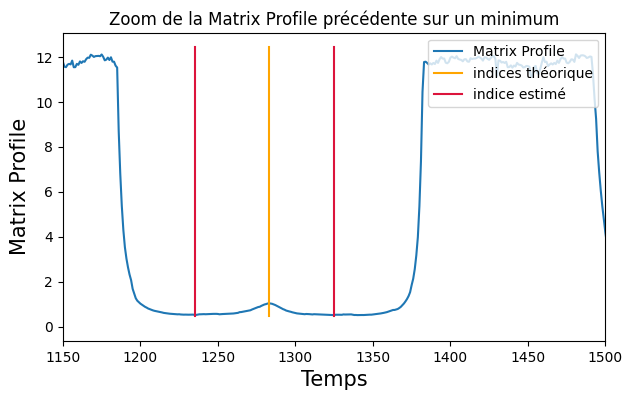

In [192]:
plt.figure(figsize=(7,4))
plt.xlabel('Temps', fontsize ='15')
plt.ylabel('Matrix Profile', fontsize='15')
plt.plot(np.arange(len(mp[:,0])),mp[:,0])

plt.plot([inds[0],inds[0]],[min(mp[:,0]),max(mp[:,0])],color='orange')

for motif in L:
    plt.plot([motif[0],motif[0]],[min(mp[:,0]),max(mp[:,0])],color='crimson')
for i in inds:
    plt.plot([i,i],[min(mp[:,0]),max(mp[:,0])],color='orange')

plt.title("Zoom de la Matrix Profile précédente sur un minimum")
plt.legend(["Matrix Profile","indices théorique","indice estimé"], loc ="upper right")
plt.xlim((1150,1500))
plt.plot([len(signal)-1],[0])

plt.show()

On remarque que de façon générale, chaque motif est détecté, mais avec un certain retard.

Sur le zoom, on voit une bosse au centre du minimum local de la Matrix Profile, cette bosse est dûe au bruit, et empêche d'avoir la bonne position du motif

#### IV/ B) 2. b/ Détection de motifs non-bruités

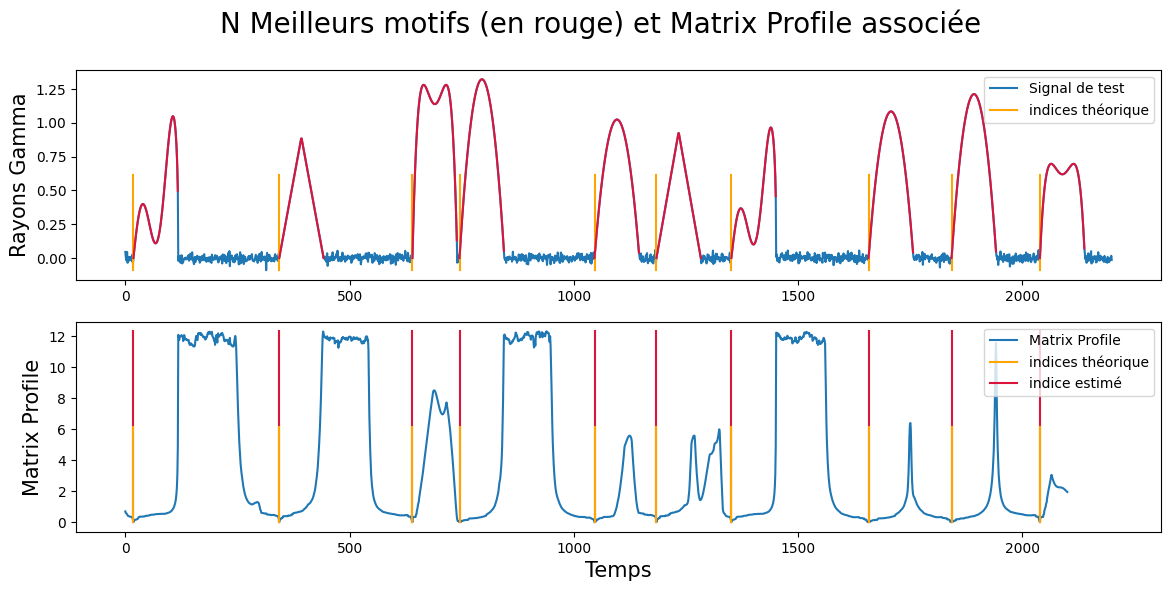

In [197]:
m = 100
N=10

motifs=[motif1,motif2,motif3,motif4]

signal,inds = signal_motifs(motifs,nbr_motif=10,
                    bruit=True, moy_bruit=0, ecart_bruit=0.02,
                    amplitude=True, ecart_amplitude=0.1, 
                    dilatation=False, dilatation_ecart=0.1,
                    bruit_sur_motif=False)
                    
data_df=pd.DataFrame({"timestamp":np.arange(len(signal)),'values': signal})


mp = stumpy.stump(data_df['values'], m)

L = select_motifs(mp,m,N)

plot_mutli_dim_theorique_et_detecte(data_df,mp,inds,L)

On voit qu'ici, tous les motifs ont été détectés parfaitement, les indices théoriques et esptimés se chevauchent.

Sans bruit, il n'y a donc plus ce problème. Peut-être pouvons nous régler ce problème dans un signal bruité en le lissant ?

#### IV/ B) 2. c/ Détection de motifs bruités après lissage par moyenne glissante

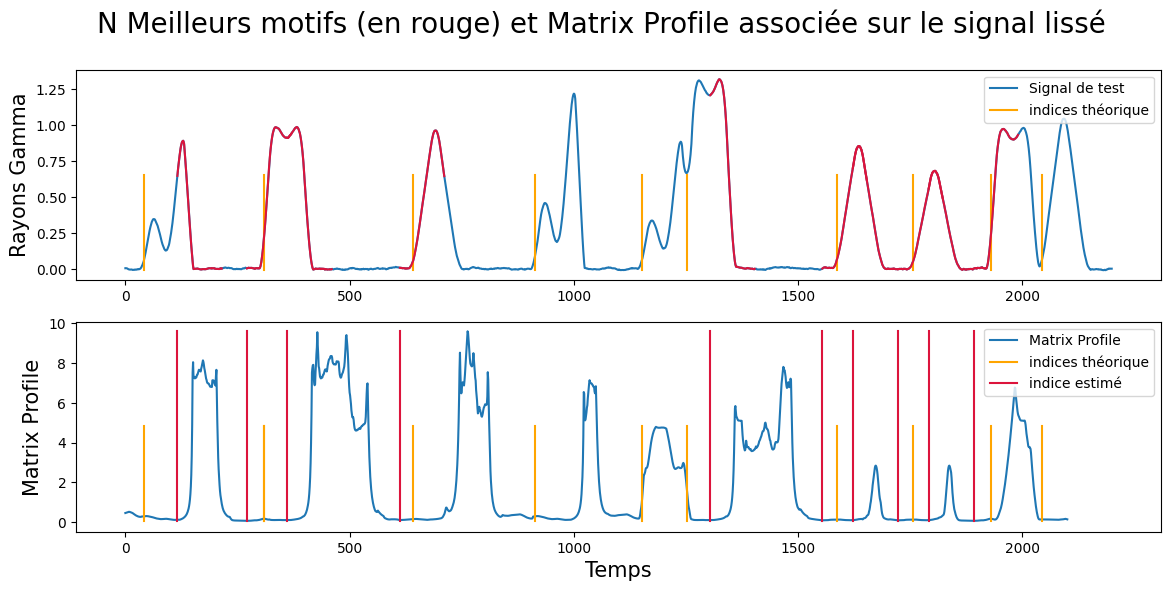

In [210]:
m = 100
N=10

motifs=[motif1,motif2,motif3,motif4]

signal,inds = signal_motifs(motifs,nbr_motif=10,
                    bruit=True, moy_bruit=0, ecart_bruit=0.02,
                    amplitude=True, ecart_amplitude=0.1, 
                    dilatation=False, dilatation_ecart=0.1,
                    bruit_sur_motif=True)
                    
signal = signal_debruite(signal,10)

data_df=pd.DataFrame({"timestamp":np.arange(len(signal)),'values': signal})


mp = stumpy.stump(data_df['values'], m)

L = select_motifs(mp,m,N)


def plot_mutli_dim_theorique_et_detecte(data_df,mp,inds,L):
    plt.figure(figsize=(14,6)) # changer la taille de la fenêtre de tracé

    plt.suptitle('N Meilleurs motifs (en rouge) et Matrix Profile associée sur le signal lissé', fontsize='20')
    plt.subplot(2,1,1)
    plt.ylabel('Rayons Gamma', fontsize='15')
    plt.plot(data_df["timestamp"],data_df["values"])

    for i in inds:
        plt.plot([i,i],[min(data_df["values"]),(min(data_df["values"])+max(data_df["values"]))/2],color='orange')
    for motif in L:
        plt.plot(data_df["timestamp"][motif[0]:motif[0]+m],data_df["values"][motif[0]:motif[0]+m],color='crimson')

    plt.legend(["Signal de test","indices théorique"], loc ="upper right")

    plt.subplot(2,1,2)
    plt.xlabel('Temps', fontsize ='15')
    plt.ylabel('Matrix Profile', fontsize='15')
    plt.plot(np.arange(len(mp[:,0])),mp[:,0])

    plt.plot([inds[0],inds[0]],[min(mp[:,0]),(min(mp[:,0])+max(mp[:,0]))/2],color='orange')

    for motif in L:
        plt.plot([motif[0],motif[0]],[min(mp[:,0]),max(mp[:,0])],color='crimson')
    for i in inds:
        plt.plot([i,i],[min(mp[:,0]),(min(mp[:,0])+max(mp[:,0]))/2],color='orange')

    plt.legend(["Matrix Profile","indices théorique","indice estimé"], loc ="upper right")

    plt.plot([len(signal)-1],[0])

    plt.show()

plot_mutli_dim_theorique_et_detecte(data_df,mp,inds,L)

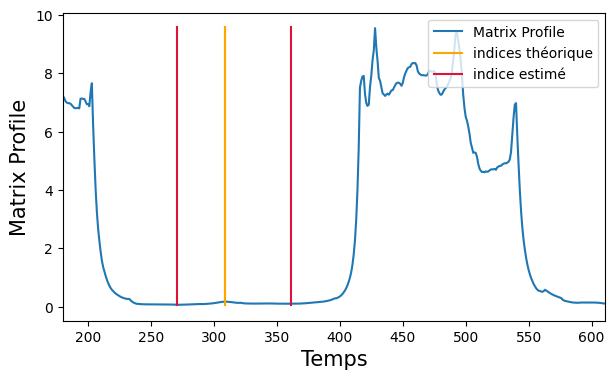

In [224]:
plt.figure(figsize=(7,4))
plt.xlabel('Temps', fontsize ='15')
plt.ylabel('Matrix Profile', fontsize='15')
plt.plot(np.arange(len(mp[:,0])),mp[:,0])

plt.plot([inds[0],inds[0]],[min(mp[:,0]),max(mp[:,0])],color='orange')

for motif in L:
    plt.plot([motif[0],motif[0]],[min(mp[:,0]),max(mp[:,0])],color='crimson')
for i in inds:
    plt.plot([i,i],[min(mp[:,0]),max(mp[:,0])],color='orange')

plt.legend(["Matrix Profile","indices théorique","indice estimé"], loc ="upper right")
plt.xlim((180,611))
plt.plot([len(signal)-1],[0])

plt.show()

On remarque ainsi que même si on lisse le signal par moyenne glissante, ce phénomène de bosse à la position théorique persiste. La bosse est simplement moins marquée mais elle est toujours là. Lisser le signal n'a en réalité absolument pas changé la position des indices des motifs détectés. 

# Conclusion
## I/ Matrix Profil et meilleur couple de motif
On a détécté le meilleur couple de motifs, d'une largeur fixé, dans un signal à l'aide de la Matrix Profile
Le résultat était très satisfaisant : les deux séquences détectées était en effet très similaires

    
## II/ Cas multidimentionnel
Si le système qui nous donne quelles dimensions il est plus pertinent de choisir et qui sélectionne les motifs en multi dimentionnel fonctionne très bien, on se rend compte que l'information apportées par les autres signaux n'est pas très intéressante. 

En effet, nous souhaitons surtout détecter des anomalies (2ème notebook) et des motifs récurrents dans le signal de rayonnement gamma. Mais comme les autres données atmosphériques n'ont pas du tout la même période caractéristique d'évolution, on ne peut pas vraiment les comparer ensemble. Le rayonnement gamma était d'ailleurs écarté par la détection automatique des dimensions les plus pertinentes alors que c'est la grandeur qui nous intéresse.

On a donc un système qui marche, mais qui n'est pas très intéressant pour notre cas, ce pourquoi on s'intéresse, dans la partie suivante, seulement au rayonnement gamma, sans utiliser cette multi-dimentionnalité

## III/ Sélection des motifs et classification
On a récupéré les minimaux locaux de la Matrix Profile les plus bas pour récupérer les motifs les plus ressemblants entre eux (et donc les plus récurrents). Puis on les a classé avec la méthode des K-means. Le résultat est très satisfaisant.

## IV/ Evaluation des performances de la méthode sur des signaux de tests
Pour vraiment pouvoir évaluer les performances et mieux comprendre certaines limites de cette méthode, nous avons construits des signaux de toutes pièces en y ajoutant des motifs, dont nous connaissons ainsi la position théorique exacte. Nous avons ainsi pu observer et comprendre la cause du décalage remarqué dans la sélection des motifs. En effet, lorsqu'il y a du bruit dans les motifs (ou qu'ils sont légèrements différents) on observe une légère bosse dans la matrix Porfile là ou on voudrait observer le minimum, d'où le décalage vers l'un des deux côtés. Même un lissage du signal avant le traitement n'annule pas ce phénomène : c'est donc belle et bien une des limites de la méthode, qu'on ne peut contourner.


Ainsi, la détection et la classification des motifs récurrents dans le signal est relativement performantes. Même si certaines limites on été observées, que ce soit la largeur des motifs qui doit être fixée manuellement, ou le manque de précision sur la position exacte des motifs dû au bruit, le système est tout de même capable de détecter un comportement/motif qui s'est déjà produit dans le passé.

Il ne reste plus alors qu'a détecter les anomalies uniques, qui ne se sont jamais produite. La deuxième méthode étudiée en deuxième partie remplira cette tâche (voir 2ème notebook).